# Multimapping analysis 
## Before running this notebook:
1. Ran `analysis2_multipmapping.sh` to generate lookup tables for all bam files 
2. Pick reads of interest: 
bed file: `data/full_intergenic.bed`
bam files:
- `analysis/longread_files/SGNex_MCF7_directcDNA_replicate1_run2/SGNex_MCF7_directcDNA_replicate1_run2.bam`
- `analysis/longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam`
- `analysis/longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2.bam`
- `analysis/illumina_files/SGNex_MCF7_Illumina_replicate2_run1/SGNex_MCF7_Illumina_replicate2_run1.bam`
- `analysis/illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1.bam`
- `analysis/illumina_files/SGNex_MCF7_Illumina_replicate4_run1/SGNex_MCF7_Illumina_replicate4_run1.bam`
Focusing on 
- `longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam`
- `illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1.bam`
Command: 
```
sed 's/^chr//' data/full_intergenic.bed > data/full_intergenic_no_chr.bed
bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam -b data/full_intergenic_no_chr.bed -bed | awk '{print $4}' > read_ids.txt


bedtools intersect -abam illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1.bam -b data/full_intergenic_no_chr.bed -bed | awk '{print $4}' > illumina_files/SGNex_MCF7_Illumina_replicate3_run1/read_ids.txt
```

awk '{print $4}'
awk '{print substr($4, 1, length($4)-2)}'

In [ ]:
# What do I need to do:
# 1. Figure out if I can just use the first value in the lookup table (I think I can)
# 2. Figure out how to rerun the lookup table code so it just prints one copy of all of the reads

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
from statannotations.Annotator import Annotator
from pathlib import Path

In [5]:
def open_files(lookup_table_path, read_ids_path, short=False):
    df = pd.read_csv(
        lookup_table_path,
        sep="\t",
        header=None,
    ).drop_duplicates(subset=0, keep="first")
    df.columns = ["read_id", "count"]

    # Read the file and store each line as an element in a list
    with open(read_ids_path, "r") as file:
        read_ids = file.readlines()
    if short:
        # remove
        read_ids = list(set([line.strip() for line in read_ids]))
    else:
        read_ids = list(set([line.strip() for line in read_ids]))
    return df, read_ids


def run_sims(df, read_ids, title, n_iterations=1000):
    l1hs_df = df[df["read_id"].isin(read_ids)]
    # Create a background distribution by random sampling
    sample_size = len(l1hs_df)
    background_distributions = []

    for _ in range(n_iterations):
        sample = df.sample(n=sample_size)
        background_distributions.append(len(sample[sample["count"] > 1]))

    count = len(l1hs_df[l1hs_df["count"] > 1])

    z_score = (count - np.mean(background_distributions)) / np.std(
        background_distributions
    )
    p_value = 1 - stats.norm.cdf(z_score)

    # Print the result
    print(
        f"Number of L1HS multi-mappingreads: {count}, Mean from background: {np.mean(background_distributions)}, STDEV: {np.std(background_distributions)} \nP-value: {p_value}"
    )

    # Plot the background distribution with the observed value
    fig, ax = plt.subplots()
    sns.histplot(background_distributions, ax=ax)
    ax.axvline(count, color="red")
    ax.set_title(title)
    ax.set_xlabel("Number of reads that are multi-mapping")
    ax.set_ylabel("Frequency")

    annotation_text = f"Observed count: {count}\nZ-score: {z_score:.2f}\nP-value < 0.001\nMean: {np.mean(background_distributions):.2f}\nSTDEV: {np.std(background_distributions):.2f}"
    # lower the annotation so it doesnt overlap with the gridlines

    ax.annotate(
        annotation_text,
        xy=(count, ax.get_ylim()[1]),
        xytext=(10, -30),
        textcoords="offset points",
        ha="left",
        va="top",
        fontsize=10,
        color="red",
        arrowprops=dict(facecolor="red", shrink=0.05),
    )

    plt.show()

Number of L1HS multi-mappingreads: 28, Mean from background: 6.029, STDEV: 2.4556382062510753 
P-value: 0.0


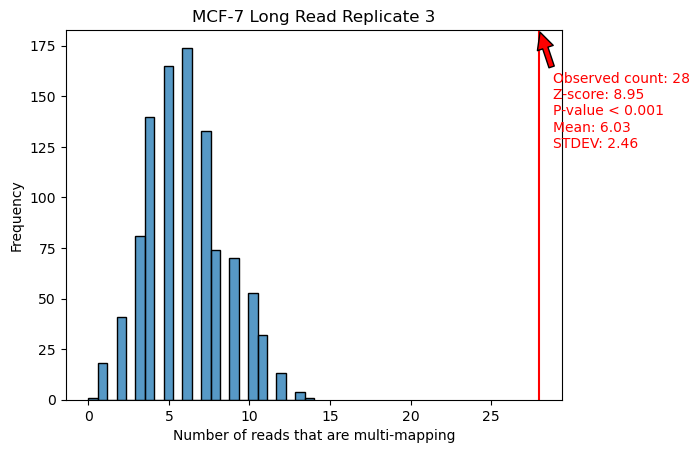

In [6]:
look_up_path = "longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3_lookup_table.txt"
read_ids_path = "longread_files/SGNex_MCF7_directcDNA_replicate3_run3/reads_id.txt"

df_long, read_ids = open_files(look_up_path, read_ids_path)
run_sims(df_long, read_ids, "MCF-7 Long Read Replicate 3")

Number of L1HS multi-mappingreads: 826, Mean from background: 57.34, STDEV: 7.0967880058516615 
P-value: 0.0


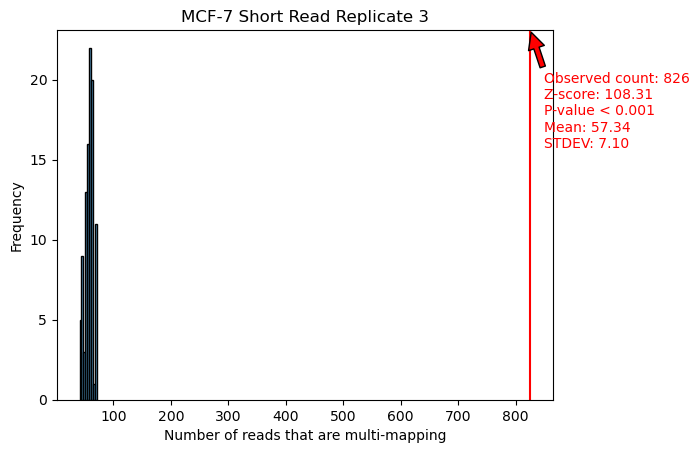

In [7]:
short_lookup = "illumina_files/SGNex_MCF7_Illumina_replicate3_run1/SGNex_MCF7_Illumina_replicate3_run1_lookup_table.txt"
short_readids = "illumina_files/SGNex_MCF7_Illumina_replicate3_run1/read_ids.txt"

df_short, read_ids = open_files(short_lookup, short_readids, True)
run_sims(df_short, read_ids, "MCF-7 Short Read Replicate 3", n_iterations=100)

<Axes: xlabel='read_type', ylabel='count'>

Error in callback <function _draw_all_if_interactive at 0x7f5bbf467d00> (for post_execute), with arguments args (),kwargs {}:


KeyboardInterrupt: 

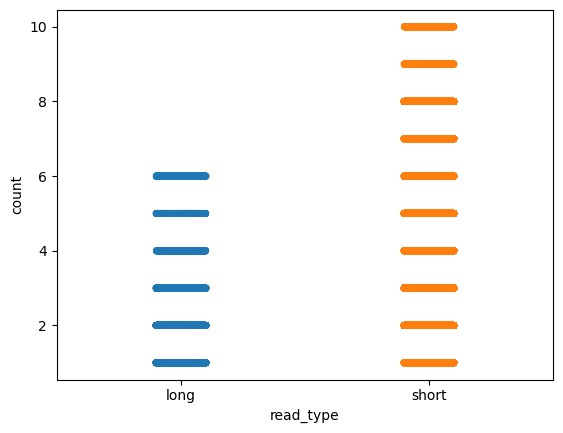

In [8]:
# merge df_long and df_short and add a column for which df they're from
df_long["read_type"] = "long"
df_short["read_type"] = "short"
df = pd.concat([df_long, df_short])
sns.stripplot(data=df, x="read_type", y="count")

In [17]:
# jitter plot with data from both replicates
fig, ax = plt.subplots()
sns.stripplot(data=df, x="count", jitter=0.2, ax=ax)

,read_id,count
0,00000a21-7076-4538-9613-da3bb8fa2c08,1
1,00000abb-0179-4fb6-a230-b33825cfbe63,1
2,00000c88-e142-4000-abc3-6c5a45a421b5,3
3,00000c88-e142-4000-abc3-6c5a45a421b5,2
4,00000c88-e142-4000-abc3-6c5a45a421b5,1
...,...,...
2951941,ffffda83-ecb1-4cca-ba75-38cda94984de,1
2951942,ffffda83-ecb1-4cca-ba75-38cda94984de,1
2951943,ffffda83-ecb1-4cca-ba75-38cda94984de,1
2951944,fffff58c-8f70-41bd-94c5-7813c8b0a368,1


In [18]:
len(df["read_id"])

2951946

In [60]:
with open(short_readids, "r") as file:
    read_ids = file.readlines()
read_ids = list(set([line.strip() for line in read_ids]))

In [61]:
read_ids

['K00151:464:H3HL2BBXY:2:1103:13443:11671/2',
 'K00151:464:H3HL2BBXY:3:2226:16985:17456/1',
 'K00151:464:H3HL2BBXY:2:1208:2301:8295/1',
 'K00151:464:H3HL2BBXY:3:2220:22790:26529/1',
 'K00151:464:H3HL2BBXY:3:1105:5792:28692/1',
 'K00151:464:H3HL2BBXY:3:1218:14783:22186/1',
 'K00151:464:H3HL2BBXY:2:1205:14397:25738/2',
 'K00151:464:H3HL2BBXY:2:2106:22587:25896/1',
 'K00151:464:H3HL2BBXY:2:1117:2808:1508/1',
 'K00151:464:H3HL2BBXY:2:2102:26007:6572/2',
 'K00151:464:H3HL2BBXY:3:2124:31649:4884/1',
 'K00151:464:H3HL2BBXY:2:1119:25093:31294/2',
 'K00151:464:H3HL2BBXY:3:2225:10774:29307/2',
 'K00151:464:H3HL2BBXY:3:2106:20334:29202/1',
 'K00151:464:H3HL2BBXY:3:2118:24231:44464/2',
 'K00151:464:H3HL2BBXY:3:2103:14387:4092/1',
 'K00151:464:H3HL2BBXY:2:1118:3508:18652/1',
 'K00151:464:H3HL2BBXY:2:1222:3072:23065/1',
 'K00151:464:H3HL2BBXY:2:1115:7547:43515/2',
 'K00151:464:H3HL2BBXY:3:2213:11525:34688/2',
 'K00151:464:H3HL2BBXY:2:1210:23510:16102/1',
 'K00151:464:H3HL2BBXY:3:2216:26808:30855/2',

In [49]:
l1hs_df = df[df["read_id"].isin(read_ids)]
# Create a background distribution by random sampling
sample_size = len(l1hs_df)
background_distributions = []

for _ in range(100):
    sample = df.sample(n=sample_size)
    background_distributions.append(len(sample[sample["count"] > 1]))

count = len(l1hs_df[l1hs_df["count"] > 1])

z_score = (count - np.mean(background_distributions)) / np.std(background_distributions)
p_value = 1 - stats.norm.cdf(z_score)

# Print the result
print(
    f"Number of L1HS multi-mappingreads: {count}, Mean from background: {np.mean(background_distributions)}, STDEV: {np.std(background_distributions)} \nP-value: {p_value}"
)

Number of L1HS multi-mappingreads: 1482, Mean from background: 1482.0, STDEV: 0.0 
P-value: nan


/netapp/LOG-G4/jfaybishenko/tmp/ipykernel_21711/4060561111.py:12: RuntimeWarning: invalid value encountered in double_scalars
  z_score = (count - np.mean(background_distributions)) / np.std(background_distributions)


In [59]:
with open(read_ids_path, "r") as file:
    read_ids = file.readlines()

list(set([line.strip() for line in read_ids]))

['72f2259d-c775-4680-b0eb-494bfc44191a',
 '4a2025bb-c967-4144-b2ab-8c6090542cd2',
 '87994fc0-ef14-4291-8ccc-20d3dc4c4b16',
 'c20fddf5-531f-4dc3-aca2-ce44cfe82eb8',
 'ccebec80-98ac-4dd5-bae2-6698de100e9a',
 '79b4aae2-49d7-499e-a649-526a761d429d',
 'f4eabbc0-a9da-40ae-bd6b-98acbc52128d',
 'e3e41365-e74f-4a6f-8e45-f6c947ce3ea0',
 'c1267df2-4bf7-4c03-a3d9-33c3ff680130',
 '8dc6a163-c543-4a68-aeb3-865aa5b586a5',
 '5e8498c1-c0e0-4ded-a14b-64e104c6bdba',
 '03b4958a-9575-458a-b920-33b66336b400',
 '105cabae-c1be-4111-907a-e1059da55c25',
 'e8a18879-c4f5-4a38-bbde-9e3731c4ed70',
 '91327d21-b436-4c45-908f-5c07019e9d89',
 '0c7a41be-e922-4d30-8c52-2e6328c7ed44',
 '5afaf869-0fb9-4255-907f-b0126b1d0d0f',
 '91e934bd-eee7-435e-9917-8b0720b85296',
 'e90d3c48-3a96-41a2-ac5d-8cd215e369ab',
 'c01190f2-a7f3-4d21-87f0-ea93d1893b2a',
 '81102e72-858f-49ba-9b93-2bbba733b0a1',
 'da2d78eb-9baa-471d-86e3-50d9812cec49',
 '74f1e848-041e-48a2-986c-9c3d5fdea074',
 'ec30c01b-7a75-4f08-ae7d-5fa961fabac2',
 '62983670-c501-

In [51]:
l1hs_df["count"].value_counts()

2     608
4     300
6     163
8     118
10     92
12     59
14     55
16     37
18     31
20     16
22      2
32      1
Name: count, dtype: int64

In [54]:
df["count"].value_counts().sort_index()

2     27113249
4      2145255
6       443818
8       118646
10      119981
12       31539
14      147017
16      374621
18       66662
20       23670
22        8209
24        2874
26        1268
28         756
30         947
32        1244
34         650
36         307
38         146
40          66
42          23
44          14
46           9
48          10
50          10
52           4
54           5
56           1
58           1
62           1
64           1
Name: count, dtype: int64

In [ ]:
# Plot the background distribution with the observed value
fig, ax = plt.subplots()
sns.histplot(background_distributions, ax=ax)
ax.axvline(count, color="red")
ax.set_title("title")
ax.set_xlabel("Number of reads mapping to L1HS")
ax.set_ylabel("Frequency")

## Multimapping and Unique Read Distribution Analysis 

In [2]:
"""
For loci type s (F1F2,F1S1,F1S2,F2S1,F2S2,S1S2): 

1. extract read IDs and alignment score 
    1. read in corresponding bed file
    2. get all read_ids
    3. get top score from sorted tsv
    4. dictionary - read_id: alignment score
2. get all loci for read ids
    1. for all bed files 
        1. for readname in bed file
            1. if readname is in all read_ids
                1. Add 1 count to dictionary 
                2. dictionary {sample: # of reads} 
        2. if bedfile is file s 
            1. drop non-duplicates lines
                1. count # of non duplicates
"""

'\nFor loci type s (F1F2,F1S1,F1S2,F2S1,F2S2,S1S2): \n\n1. extract read IDs and alignment score \n    1. read in corresponding bed file\n    2. get all read_ids\n    3. get top score from sorted tsv\n    4. dictionary - read_id: alignment score\n2. get all loci for read ids\n    1. for all bed files \n        1. for readname in bed file\n            1. if readname is in all read_ids\n                1. Add 1 count to dictionary \n                2. dictionary {sample: # of reads} \n        2. if bedfile is file s \n            1. drop non-duplicates lines\n                1. count # of non duplicates\n'

In [19]:
def make_barplots(base_path):
    samples = [
        "full_intergenic_AS",
        "full_intronic_AS",
        "truncate_intergenic_AS",
        "truncate_intronic_AS",
    ]
    read_counts = {sample: [] for sample in samples}
    for sample in samples:
        if Path(f"{base_path}/{sample}.bed").stat().st_size == 0:
            # append zero to all samples
            [read_counts[sample].append(0) for sample in samples]
            continue

        bed_df = pd.read_csv(f"{base_path}/{sample}.bed", sep="\t", header=None)
        read_ids = bed_df[3].unique()
        for bed_file_prefix in samples:
            # if file is empty then skip
            if Path(f"{base_path}/{bed_file_prefix}.bed").stat().st_size == 0:
                read_counts[bed_file_prefix].append(0)
                continue

            bed_df = pd.read_csv(
                f"{base_path}/{bed_file_prefix}.bed", sep="\t", header=None
            )
            if sample == bed_file_prefix:
                # drop unique lines
                bed_df = bed_df[bed_df.duplicated(subset=3, keep=False)]
                # get number of non-duplicates
                read_counts[bed_file_prefix].append(
                    len(bed_df) - len(bed_df.drop_duplicates(subset=3))
                )
                continue
            read_counts[bed_file_prefix].append(len(bed_df[bed_df[3].isin(read_ids)]))

    # Transforming data to the desired format for plotting
    df = pd.DataFrame(read_counts)
    # Transposing the DataFrame to get categories on the x-axis and values stacked
    df = df.T
    df.columns = samples

    # Plotting
    fig, ax = plt.subplots()
    df.plot(kind="bar", stacked=True, ax=ax)

    # Setting titles and labels
    ax.set_xlabel("Categories")
    ax.set_ylabel("Number of reads")
    ax.set_title(f"{base_path} Read Counts For Different Loci Categories")
    plt.xticks(rotation=45)

    plt.tight_layout()  # Adjust layout to make room for the rotated x-axis labels
    plt.show()

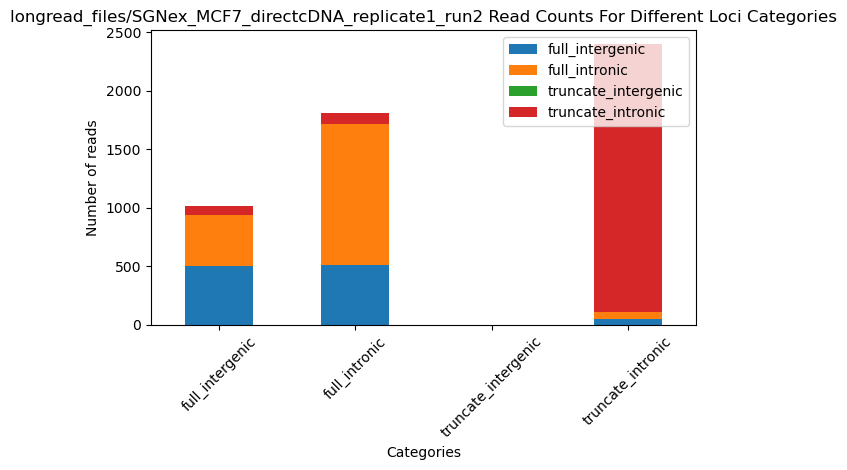

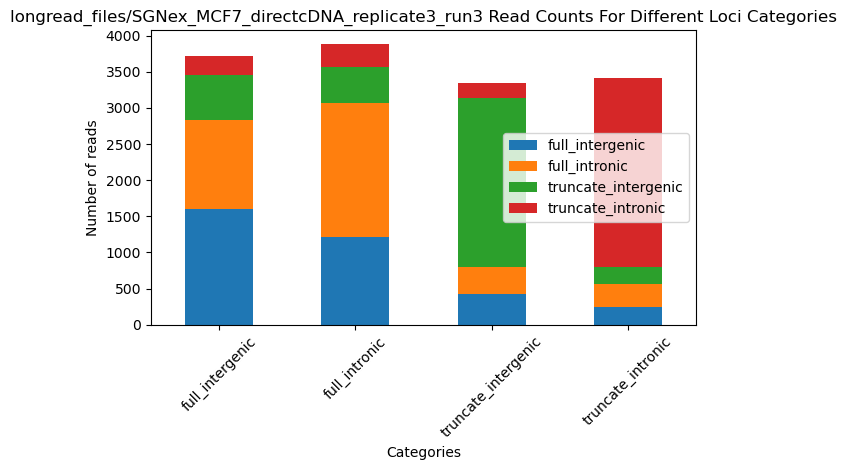

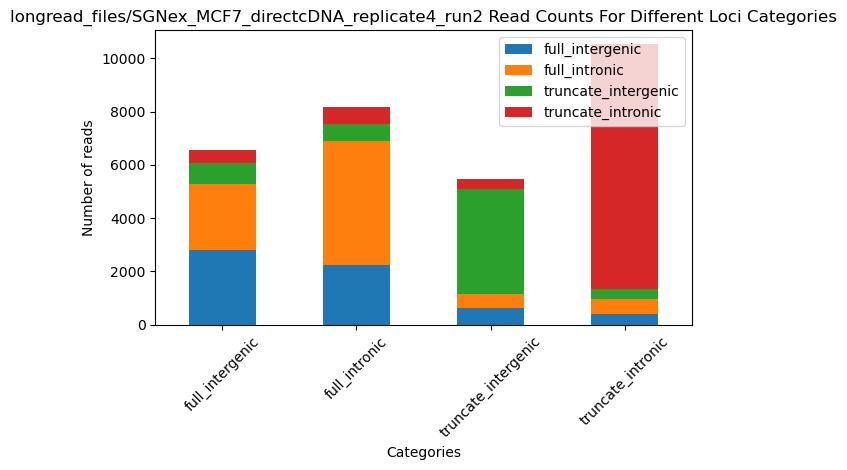

In [21]:
basepaths = [
    "longread_files/SGNex_MCF7_directcDNA_replicate1_run2",
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3",
    "longread_files/SGNex_MCF7_directcDNA_replicate4_run2",
]

for path in basepaths:
    make_barplots(path)

## This is the first version where it is NOT just highest alignment scores

```
bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam -b data/full_intergenic_no_chr.bed -bed > longread_files/SGNex_MCF7_directcDNA_replicate4_run2/full_intergenic_AS.bed

bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam -b data/full_intergenic_no_chr.bed -bed > longread_files/SGNex_MCF7_directcDNA_replicate4_run2/full_intergenic_AS.bed

bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam -b data/full_intergenic_no_chr.bed -bed > longread_files/SGNex_MCF7_directcDNA_replicate4_run2/full_intergenic_AS.bed

bedtools intersect -abam longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam -b data/full_intergenic_no_chr.bed -bed > longread_files/SGNex_MCF7_directcDNA_replicate4_run2/full_intergenic_AS.bed
```

In [27]:
import pysam
import subprocess


def run_bedtools_intersect(file_path):

    prefix = "/".join(file_path.split("/")[:-1])
    for bed_file in [
        "full_intergenic_no_chr.bed",
        "full_intronic_no_chr.bed",
        "truncate_intergenic_no_chr.bed",
        "truncate_intronic_no_chr.bed",
    ]:
        cmd = [  # TODO add/change some flags (-wa, something else?)
            "bedtools",
            "intersect",
            "-abam",
            file_path,
            "-b",
            "data/" + bed_file,
            "-bed",
        ]
        output_file = f"{prefix}/{'_'.join(bed_file.split('_')[:2])}_AS.bed"

        with open(output_file, "w") as outfile:
            subprocess.run(cmd, stdout=outfile)


def process_bams(bam_file):

    # get top alignment score
    sorted_tsv = bam_file.split(".")[0] + ".sorted.tsv"
    df = pd.read_csv(
        sorted_tsv,
        sep="\t",
        header=None,
    )

    # iterate through df rows
    # for each new value in col 0, save the first value in col 1
    # save the read_id and alignment score in a dictionary

    read_scores = {}
    for row in df.itertuples():
        if row[1] not in read_scores:
            read_scores[row[1]] = row[2]

    # Open the input and output BAM files
    input_bam = pysam.AlignmentFile(bam_file, "rb")
    output_bam = pysam.AlignmentFile(bam_file + "_TOP_AS.bam", "wb", template=input_bam)

    for read in input_bam:
        # if AS tag is not present then skip
        if read.has_tag("AS"):
            # if read is multimapped then skip
            if read_scores[read.query_name] == read.get_tag("AS"):
                output_bam.write(read)

    input_bam.close()
    output_bam.close()

    run_bedtools_intersect(bam_file + "_TOP_AS.bam")

In [28]:
run_bedtools_intersect(
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam"
)

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-



***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam_TOP_AS.bam has inconsistent naming convention for record:
chrIS	61634	96460	e1f1d0af-48d4-40d4-9a23-c7c88e6b0a55	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replica

In [30]:
run_bedtools_intersect(
    "longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam"
)

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam has inconsistent naming convention for record:
chrIS	30008	96458	72ccb87b-ee09-443a-81f9-f75f2c84553d	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam has inconsistent naming convention for record:
chrIS	30008	96458	72ccb87b-ee09-443a-81f9-f75f2c84553d	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam has inconsistent naming convention for record:
chrIS	30008	96458	72ccb87b-ee09-443a-81f9-f75f2c84553d	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2_TOP_AS.bam has inconsistent naming convention for record:
chrIS	30008	96458	72ccb87b-ee09-443a-81f9-f75f2c84553d	60	-

***** WARNING: File longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_M

In [33]:
run_bedtools_intersect(
    "longread_files/SGNex_MCF7_directcDNA_replicate1_run2/SGNex_MCF7_directcDNA_replicate1_run2.bam_TOP_AS.bam"
)

In [ ]:
"""bampaths = ['longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam',
			'longread_files/SGNex_MCF7_directcDNA_replicate1_run2/SGNex_MCF7_directcDNA_replicate1_run2.bam',
			'longread_files/SGNex_MCF7_directcDNA_replicate4_run2/SGNex_MCF7_directcDNA_replicate4_run2.bam']
			
for path in bampaths: 
	process_bams(path)"""

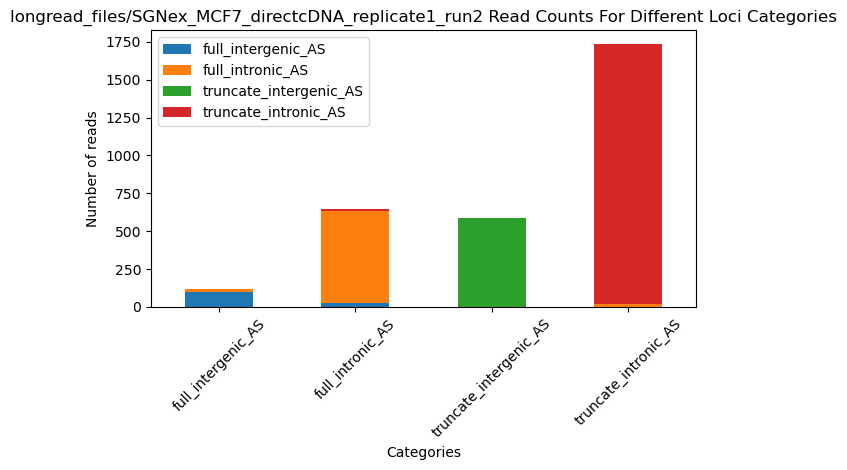

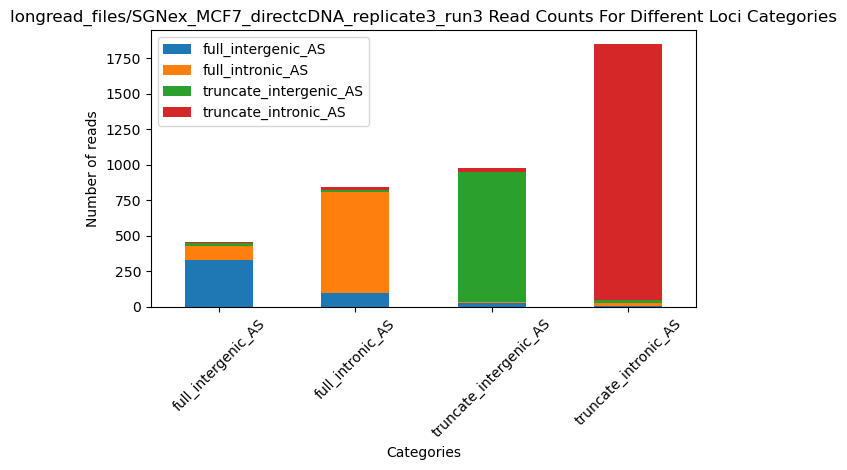

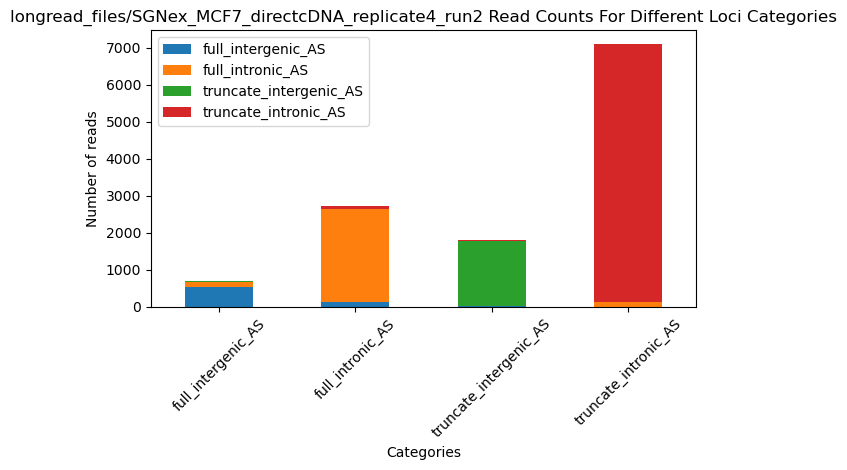

In [34]:
basepaths = [
    "longread_files/SGNex_MCF7_directcDNA_replicate1_run2",
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3",
    "longread_files/SGNex_MCF7_directcDNA_replicate4_run2",
]

for path in basepaths:
    make_barplots(path)

# Upset plot

In [12]:
def read_data(base_path):
    samples = [
        "full_intergenic_AS",
        "full_intronic_AS",
        "truncate_intergenic_AS",
        "truncate_intronic_AS",
    ]

    master_read_info = {}
    individual_read_info = {
        sample: 0 for sample in samples + [sample2 + "_unique" for sample2 in samples]
    }

    ids = {}
    # get list of read_ids for each sample
    for sample in samples:
        if Path(f"{base_path}/{sample}.bed").stat().st_size == 0:
            # append zero to all samples
            ids[sample] = set()
            continue
        bed_df = pd.read_csv(f"{base_path}/{sample}.bed", sep="\t", header=None)
        read_ids = bed_df[3].unique()
        ids[sample] = set(read_ids)

    # iterate through reads in bam file
    bam_file = f"{base_path}/{base_path.split('/')[-1]}.bam"
    input_bam = pysam.AlignmentFile(bam_file, "rb")

    for read in input_bam:
        # if AS tag is not present then skip
        if read.has_tag("AS"):
            # get read_id
            read_id = read.query_name
            master_read_info[read_id] = individual_read_info.copy()
            # if read exists in any of the ids categorys, add 1 to the count
            for k, v in ids.items():
                if read_id in v:
                    master_read_info[read_id][k] += 1
            # if read is unique to any of the ids categorys, add 1 to the count

    """	for bed_file_prefix in samples:
			# if file is empty then skip
			if Path(f"{base_path}/{bed_file_prefix}.bed").stat().st_size == 0:
				read_counts[bed_file_prefix].append(0)
				continue
			
			bed_df = pd.read_csv(f"{base_path}/{bed_file_prefix}.bed", sep="\t", header=None)
			if sample == bed_file_prefix:
				# drop unique lines
				bed_df = bed_df[bed_df.duplicated(subset=3,keep=False)]
				# get number of non-duplicates
				read_counts[bed_file_prefix].append(len(bed_df) - len(bed_df.drop_duplicates(subset=3)))
				continue
			read_counts[bed_file_prefix].append(len(bed_df[bed_df[3].isin(read_ids)]))

	# Transforming data to the desired format for plotting
	df = pd.DataFrame(read_counts)
	# Transposing the DataFrame to get categories on the x-axis and values stacked
	df = df.T
	df.columns = samples"""

    return df

In [3]:
from upsetplot import UpSet, from_memberships
from matplotlib import pyplot as plt
import pandas as pd
from pathlib import Path
import pysam
import numpy as np
from collections import Counter, defaultdict

In [2]:
def read_data(base_path, top_alignments=True):
    categories = [
        "full_intergenic",
        "full_intronic",
        "truncate_intergenic",
        "truncate_intronic",
    ]

    # make a counter of all read_ids and mappings across catgeories
    if top_alignments:
        overall_mapping = Counter(
            [
                item
                for sublist in [
                    pd.read_csv(
                        f"{base_path}/{cat}_AS.bed", sep="\t", header=None
                    ).drop_duplicates()[3]
                    for cat in categories
                ]
                for item in sublist
            ]
        )
    else:
        overall_mapping = Counter(
            [
                item
                for sublist in [
                    pd.read_csv(
                        f"{base_path}/{cat}.bed", sep="\t", header=None
                    ).drop_duplicates()[3]
                    for cat in categories
                ]
                for item in sublist
            ]
        )

    ids = {}
    # get list of read_ids for each sample
    for cat in categories:
        ids[cat + "_multi"] = {}
        ids[cat + "_unique"] = {}

        # if bed file is empty
        if top_alignments:
            if Path(f"{base_path}/{cat}_AS.bed").stat().st_size == 0:
                continue
            bed_df = pd.read_csv(
                f"{base_path}/{cat}_AS.bed", sep="\t", header=None
            ).drop_duplicates()
        else:
            if Path(f"{base_path}/{cat}.bed").stat().st_size == 0:
                continue
            bed_df = pd.read_csv(
                f"{base_path}/{cat}.bed", sep="\t", header=None
            ).drop_duplicates()

        # iterate through counter and seperate values equal to 1 and values greater than 1
        for k, v in Counter(bed_df[3]).items():
            if overall_mapping[k] > 1:
                ids[cat + "_multi"][k] = v
            else:
                ids[cat + "_unique"][k] = v

    # Create a DataFrame indicating whether a read ID is in each category
    df = pd.DataFrame(ids).fillna(0).astype(int)

    # make a membership column to know which categories each read is in
    df["membership"] = df.apply(
        lambda row: ",".join([col for col in df.columns if row[col]]),
        axis=1,
    )
    return from_memberships(df.membership.str.split(","), data=df)

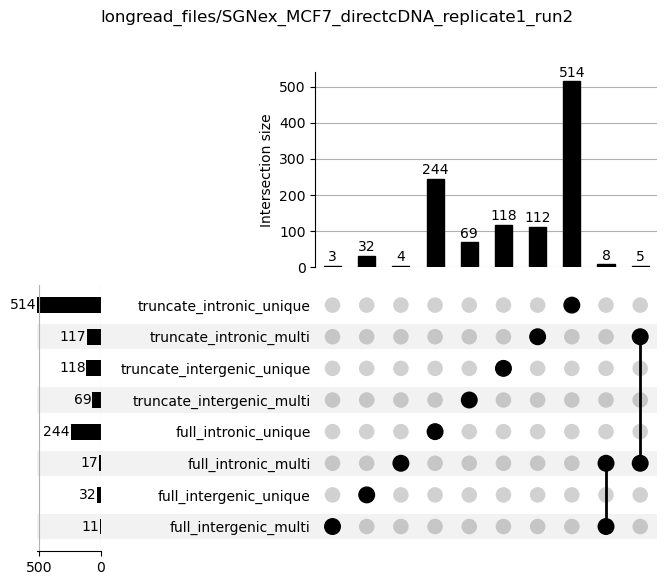

<Figure size 640x480 with 0 Axes>

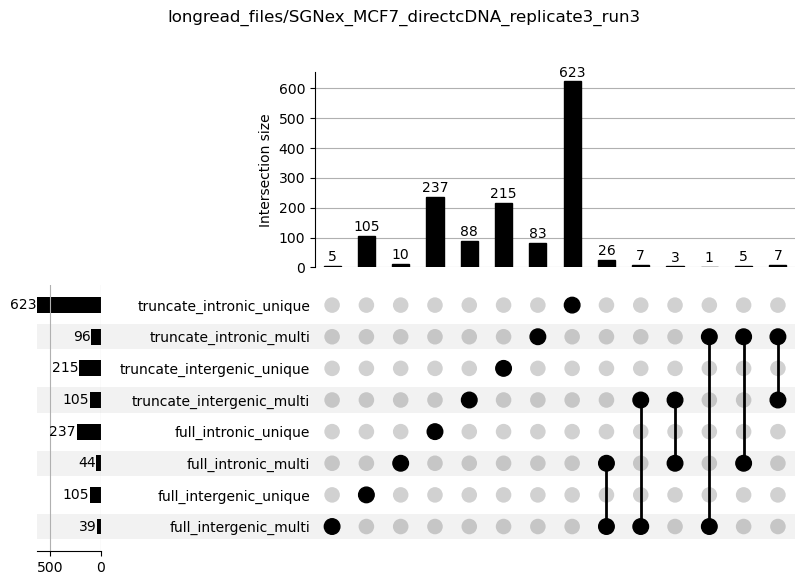

<Figure size 640x480 with 0 Axes>

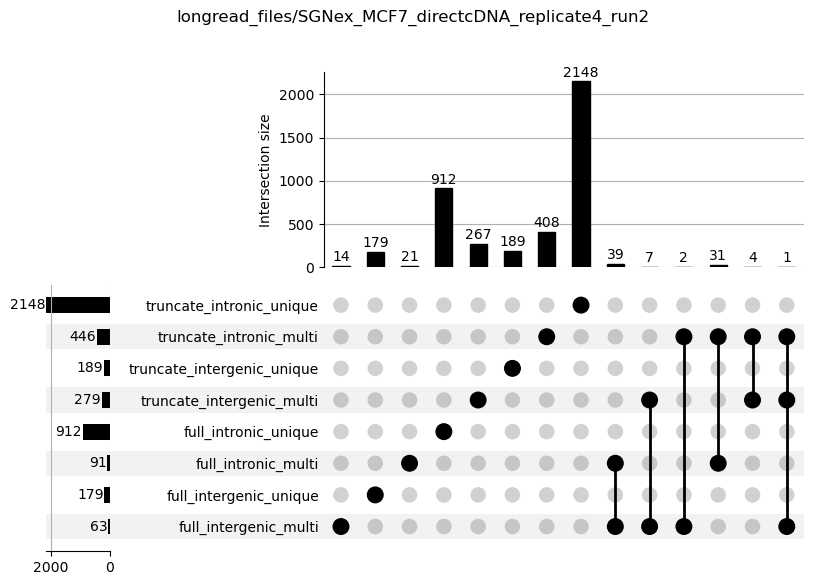

<Figure size 640x480 with 0 Axes>

In [8]:
order = [
    "full_intergenic_multi",
    "full_intergenic_unique",
    "full_intronic_multi",
    "full_intronic_unique",
    "truncate_intergenic_multi",
    "truncate_intergenic_unique",
    "truncate_intronic_multi",
    "truncate_intronic_unique",
]
basepaths = [
    "longread_files/SGNex_MCF7_directcDNA_replicate1_run2",
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3",
    "longread_files/SGNex_MCF7_directcDNA_replicate4_run2",
]

for path in basepaths:
    data = read_data(path)

    # us = data.reset_index().drop(columns=[np.nan]).set_index(samples)
    UpSet(data, subset_size="auto", show_counts=True, sort_categories_by="input").plot()
    plt.suptitle(path)
    plt.show()
    plt.clf()

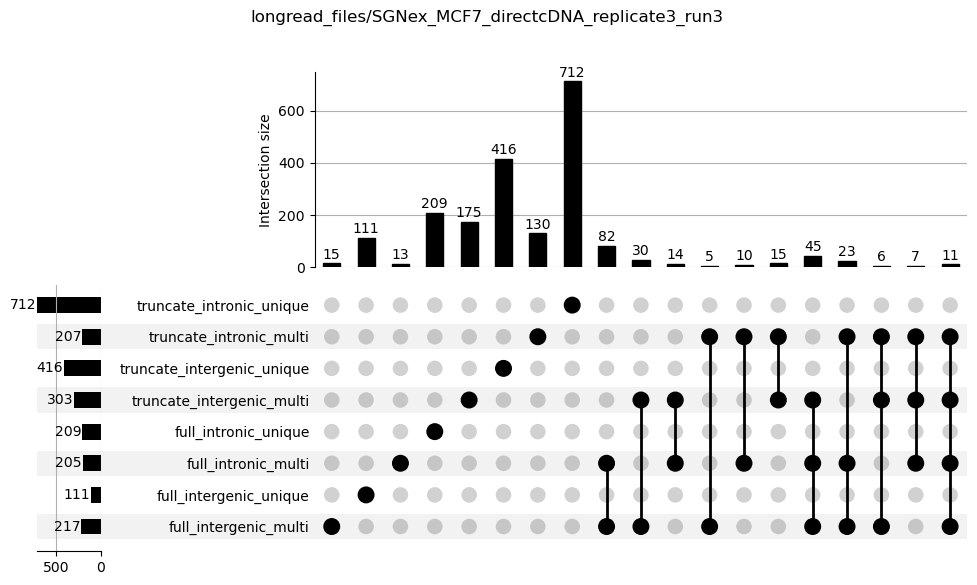

<Figure size 640x480 with 0 Axes>

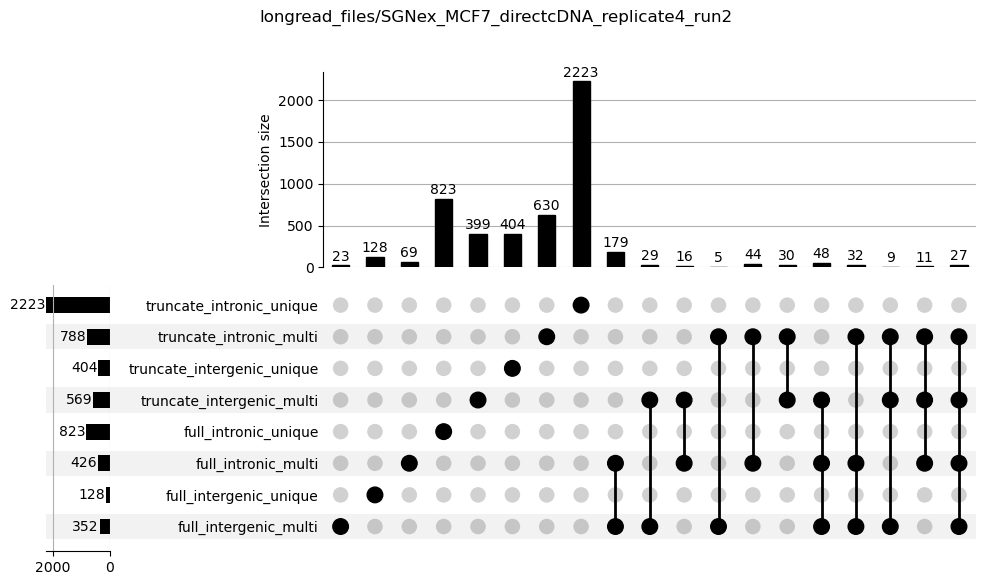

<Figure size 640x480 with 0 Axes>

In [10]:
basepaths = [
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3",
    "longread_files/SGNex_MCF7_directcDNA_replicate4_run2",
]

for path in basepaths:
    data = read_data(path, False)
    # us = data.reset_index().drop(columns=[np.nan]).set_index(samples)
    UpSet(data, subset_size="auto", show_counts=True, sort_categories_by="input").plot()
    plt.suptitle(path)
    plt.show()
    plt.clf()

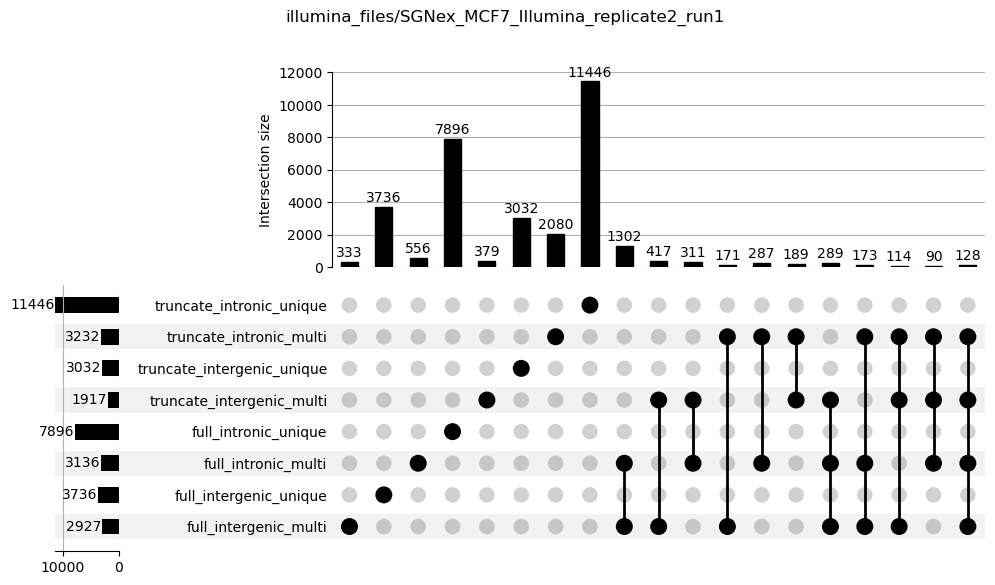

<Figure size 640x480 with 0 Axes>

In [11]:
basepaths = ["illumina_files/SGNex_MCF7_Illumina_replicate2_run1"]

for path in basepaths:
    data = read_data(path, False)
    # us = data.reset_index().drop(columns=[np.nan]).set_index(samples)
    UpSet(data, subset_size="auto", show_counts=True, sort_categories_by="input").plot()
    plt.suptitle(path)
    plt.show()
    plt.clf()

What's going in the next block?


1. We take the sorted tsv which is read, alignment score --> get the top alignment score for each read
2. iterate through the bam and count each read that has its top alignment score -- ISSUE? If something has multiple reads but only one top score, is it unique or multimapping?
3. next iterate through categories seperate reads that exist in category. Then count the number of unique and multimapping reads in the bed_file (which may be wrong)

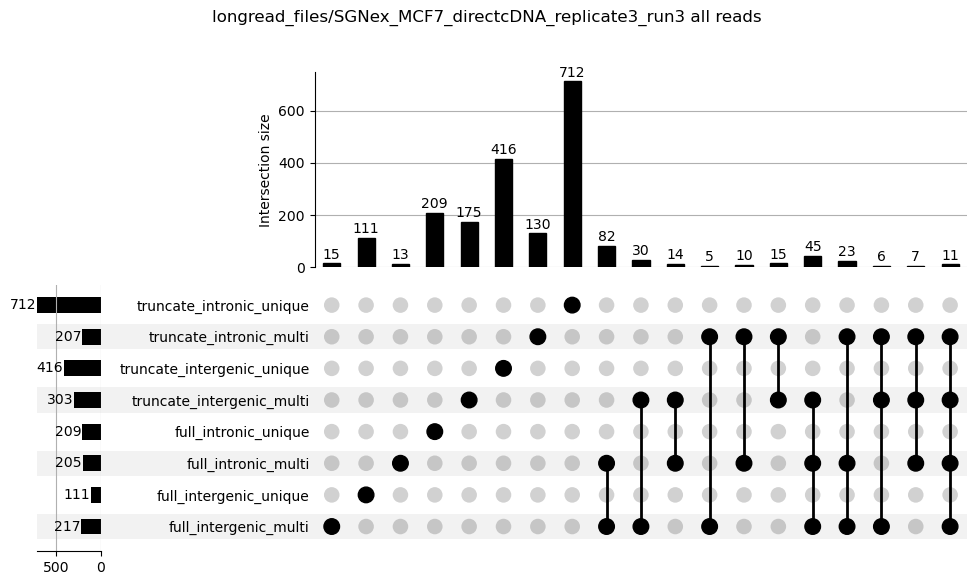

<Figure size 640x480 with 0 Axes>

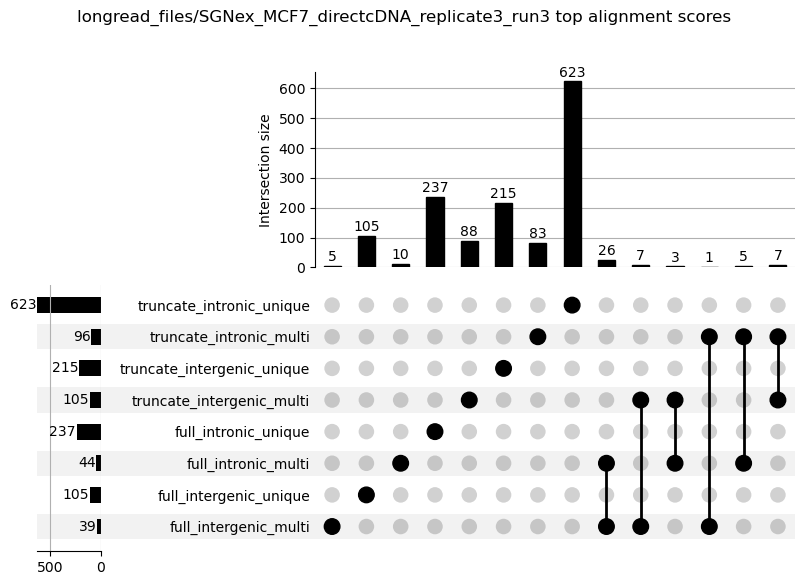

<Figure size 640x480 with 0 Axes>

In [22]:
basepaths = [
    "longread_files/SGNex_MCF7_directcDNA_replicate3_run3",
]

for path in basepaths:
    data = read_data(path, False)
    # us = data.reset_index().drop(columns=[np.nan]).set_index(samples)
    UpSet(data, subset_size="auto", show_counts=True, sort_categories_by="input").plot()
    plt.suptitle(path + " all reads")
    plt.show()
    plt.clf()

    data = read_data(path)
    # us = data.reset_index().drop(columns=[np.nan]).set_index(samples)
    UpSet(data, subset_size="auto", show_counts=True, sort_categories_by="input").plot()
    plt.suptitle(path + " top alignment scores")
    plt.show()
    plt.clf()

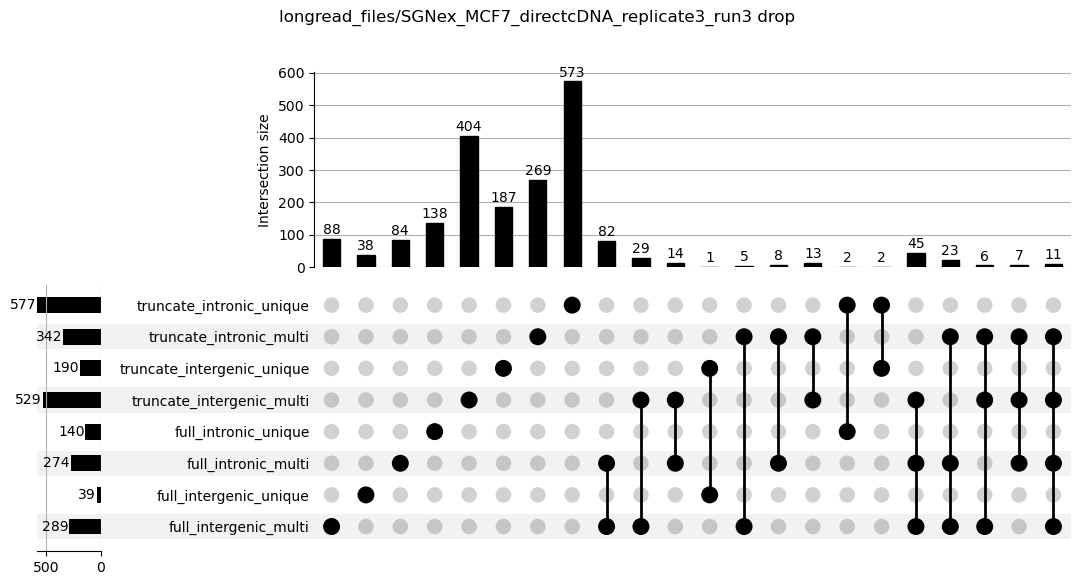

<Figure size 640x480 with 0 Axes>

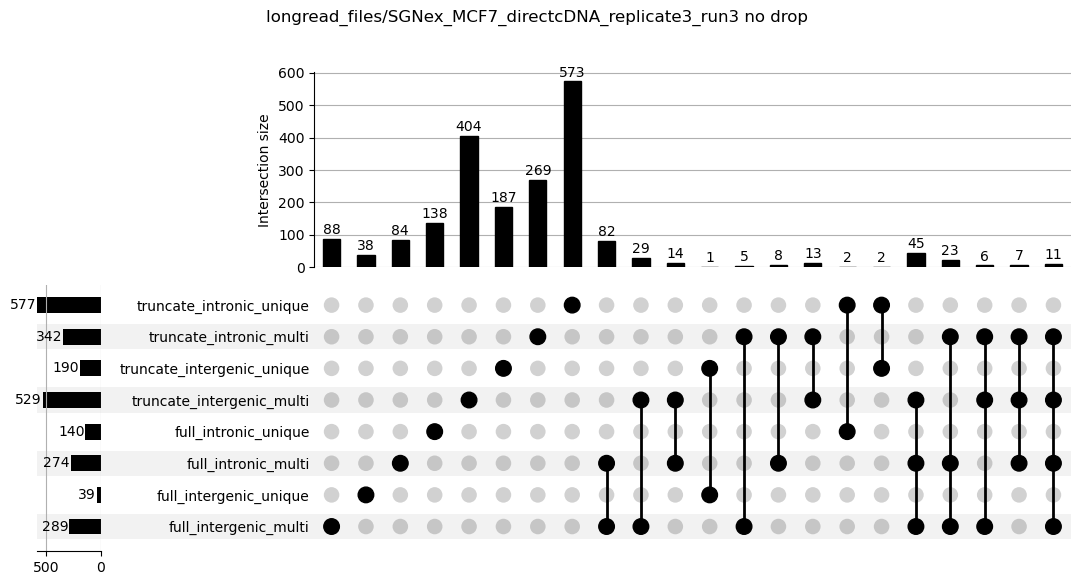

<Figure size 640x480 with 0 Axes>

In [20]:
## Ok lets redo these
base_path = "longread_files/SGNex_MCF7_directcDNA_replicate3_run3"
bam_file = "longread_files/SGNex_MCF7_directcDNA_replicate3_run3/SGNex_MCF7_directcDNA_replicate3_run3.bam"

"""sorted_tsv = bam_file.split(".")[0] + ".sorted.tsv"
df = pd.read_csv(
	sorted_tsv,
	sep="\t",
	header=None,
)

# iterate through df rows
# for each new value in col 0, save the first value in col 1
# save the read_id and alignment score in a dictionary

read_scores = {}
for row in df.itertuples():
	if row[1] not in read_scores:
		read_scores[row[1]] = row[2]

# Open the input and output BAM files
read_counts = defaultdict(int)
input_bam = pysam.AlignmentFile(bam_file, "rb")

for read in input_bam:
	# if AS tag is not present then skip
	if read.has_tag("AS"):
		# if read is multimapped then skip
		read_counts[read.query_name] += 1
input_bam.close()


unique_reads = [k for k, v in read_counts.items() if v == 1]"""


categories = [
    "full_intergenic",
    "full_intronic",
    "truncate_intergenic",
    "truncate_intronic",
]


ids = {}
# get list of read_ids for each sample
for cat in categories:
    ids[cat + "_multi"] = defaultdict(int)
    ids[cat + "_unique"] = defaultdict(int)

    # if bed file is empty
    if Path(f"{base_path}/{cat}.bed").stat().st_size == 0:
        continue
    bed_df = pd.read_csv(
        f"{base_path}/{cat}.bed", sep="\t", header=None
    ).drop_duplicates()

    # iterate through counter and seperate values equal to 1 and values greater than 1
    for k in bed_df[3]:
        if k in unique_reads:
            ids[cat + "_unique"][k] += 1
        else:
            ids[cat + "_multi"][k] += 1


# Create a DataFrame indicating whether a read ID is in each category
df = pd.DataFrame(ids).fillna(0).astype(int)

# make a membership column to know which categories each read is in
df["membership"] = df.apply(
    lambda row: ",".join([col for col in df.columns if row[col]]),
    axis=1,
)
final_df = from_memberships(df.membership.str.split(","), data=df)


UpSet(final_df, subset_size="auto", show_counts=True, sort_categories_by="input").plot()
plt.suptitle(base_path + " drop")
plt.show()
plt.clf()

ids = {}
# get list of read_ids for each sample
for cat in categories:
    ids[cat + "_multi"] = defaultdict(int)
    ids[cat + "_unique"] = defaultdict(int)

    # if bed file is empty
    if Path(f"{base_path}/{cat}.bed").stat().st_size == 0:
        continue
    bed_df = pd.read_csv(
        f"{base_path}/{cat}.bed", sep="\t", header=None
    )  # .drop_duplicates()

    # iterate through counter and seperate values equal to 1 and values greater than 1
    for k in bed_df[3]:
        if k in unique_reads:
            ids[cat + "_unique"][k] += 1
        else:
            ids[cat + "_multi"][k] += 1


# Create a DataFrame indicating whether a read ID is in each category
df = pd.DataFrame(ids).fillna(0).astype(int)

# make a membership column to know which categories each read is in
df["membership"] = df.apply(
    lambda row: ",".join([col for col in df.columns if row[col]]),
    axis=1,
)
final_df = from_memberships(df.membership.str.split(","), data=df)


UpSet(final_df, subset_size="auto", show_counts=True, sort_categories_by="input").plot()
plt.suptitle(base_path + " no drop")
plt.show()
plt.clf()

In [16]:
df.sum(axis=0)

full_intergenic_multi                                                       289
full_intergenic_unique                                                       39
full_intronic_multi                                                         274
full_intronic_unique                                                        140
truncate_intergenic_multi                                                   529
truncate_intergenic_unique                                                  190
truncate_intronic_multi                                                     342
truncate_intronic_unique                                                    577
membership                    full_intergenic_multifull_intergenic_multi,ful...
dtype: object

In [5]:
# subset read_counts to only include reads in bed_df[3]
# make a new dataframe with the subsetted read_counts

sub_read_counts = {k: v for k, v in read_counts.items() if k in bed_df[3].values}


sub_read_counts

{'77dfd7c7-5588-40cc-82eb-47fd620659d0': 1,
 '37f152bd-51b0-4546-92dc-eddbc56de761': 1,
 '77ea4d45-89c6-426b-a3e6-0382e9f6dc0c': 1,
 '09e71118-daf3-429b-aeee-de76ed7045af': 1,
 '90a5505d-6b43-49dc-8a8b-4aebd4aa08fd': 1,
 '9dcef4b7-3956-4e40-a787-4b4ba0fe665a': 1,
 '1bbd9daa-7490-4795-9eb5-c05d45f852a5': 1,
 'b2ac9d8c-74de-48f4-8aaf-927606117423': 1,
 '17d2d3f8-503a-4c55-90d8-b6e96cd09a29': 1,
 '1fc49997-91b9-45d1-8003-947cac704202': 1,
 'd43d5fd7-e4a8-4c71-84ad-ceae5c21ea9d': 1,
 '64d13a72-03c6-4720-aff6-df0df0a9f5cc': 1,
 'dd32c9f6-ce3a-4e09-88dd-46dae55c1a20': 1,
 'e2a97de6-fca0-4420-a236-16a4056d7a8a': 1,
 'c1f98094-732b-4a17-b40d-e78355e4fea4': 1,
 '638b3bab-865c-4f0d-9244-ee4d672f5ebf': 1,
 '6d6a2c20-3012-4773-ab32-0aa107a90d0f': 1,
 '63f951d1-89cd-492a-a94f-8be87a679f71': 1,
 '5f74990d-3162-4438-98ff-0318ed543b7f': 1,
 '25018e62-812a-4be4-9d42-73f05c1f6642': 2,
 'f611e8fe-5de8-4851-b8ad-37aac35cb485': 1,
 '9a5a9a9f-d2aa-45c9-8e9f-981909fc31dc': 1,
 'c27d8f25-59db-4e01-bd06-a14d53

In [10]:
sep_read_counts = {}
new_ids = {}
for cat in categories:
    new_ids[cat + "_multi"] = defaultdict(int)
    new_ids[cat + "_unique"] = defaultdict(int)

    # if bed file is empty
    if Path(f"{base_path}/{cat}.bed").stat().st_size == 0:
        continue
    bed_df = pd.read_csv(
        f"{base_path}/{cat}.bed", sep="\t", header=None
    ).drop_duplicates()

    sep_read_counts[cat] = {
        k: v for k, v in read_counts.items() if k in bed_df[3].values
    }  # TODO: This is wrong, need to get read_counts for each category instead of across categories
    # iterate through counter and seperate values equal to 1 and values greater than 1
    for k, v in sep_read_counts[cat].items():
        if k not in unique_reads:
            new_ids[cat + "_multi"][k] += v
        else:
            new_ids[cat + "_unique"][k] += v

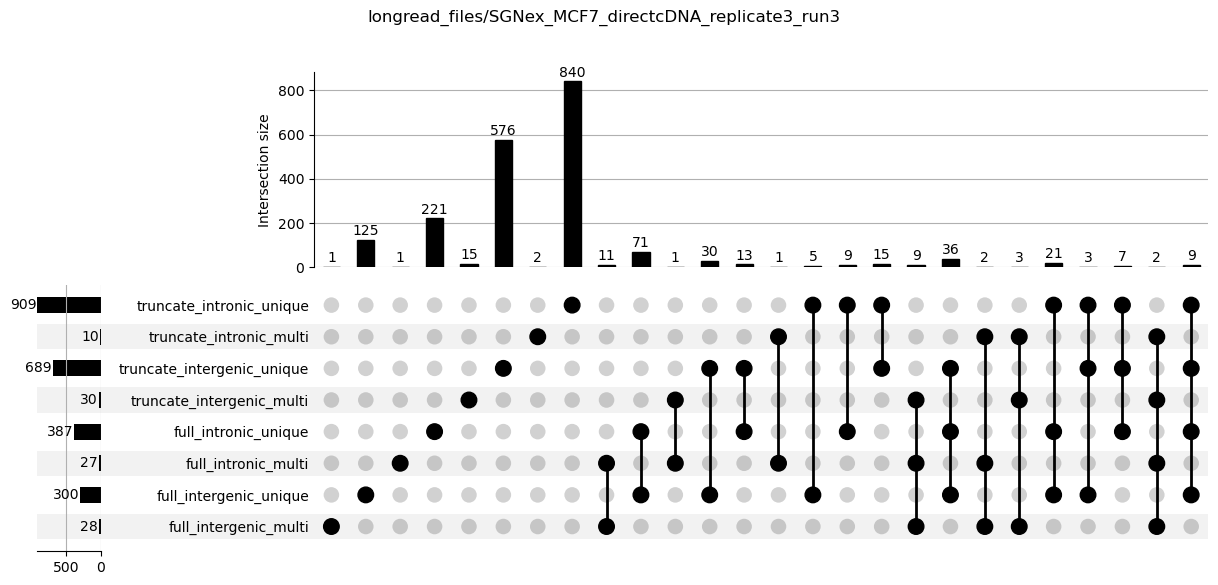

<Figure size 640x480 with 0 Axes>

In [11]:
df = pd.DataFrame(new_ids).fillna(0).astype(int)

# make a membership column to know which categories each read is in
df["membership"] = df.apply(
    lambda row: ",".join([col for col in df.columns if row[col]]),
    axis=1,
)
final_df = from_memberships(df.membership.str.split(","), data=df)


UpSet(final_df, subset_size="auto", show_counts=True, sort_categories_by="input").plot()
plt.suptitle(base_path)
plt.show()
plt.clf()

In [13]:
df.sum(axis=0)

full_intergenic_multi                                                        62
full_intergenic_unique                                                      300
full_intronic_multi                                                          60
full_intronic_unique                                                        387
truncate_intergenic_multi                                                    63
truncate_intergenic_unique                                                  689
truncate_intronic_multi                                                      20
truncate_intronic_unique                                                    909
membership                    full_intergenic_multi,full_intronic_multi,trun...
dtype: object